# Examples to load / use the watermarking class

## Load libraries

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Our stuff !
from watermarker import BlockMark

## Setup

### Load image

In [2]:
img = cv2.imread("img/lenna.png", 0)

### Set the class

In [3]:
md = BlockMark(mode="add", alpha=2)

In [4]:
i = md.get_max_capacity(img)
print("Can write at best {} bits ({} bytes)".format(i, i//8))

Can write at best 106496 bits (13312 bytes)


### Message

In [5]:
n = 40000
seq = np.random.randint(0, 2, n)

## Encode

In [6]:
img_watermarked = md.encode(img, seq)

MSE: 0.64154 pix²
PSNR: 50.059 db


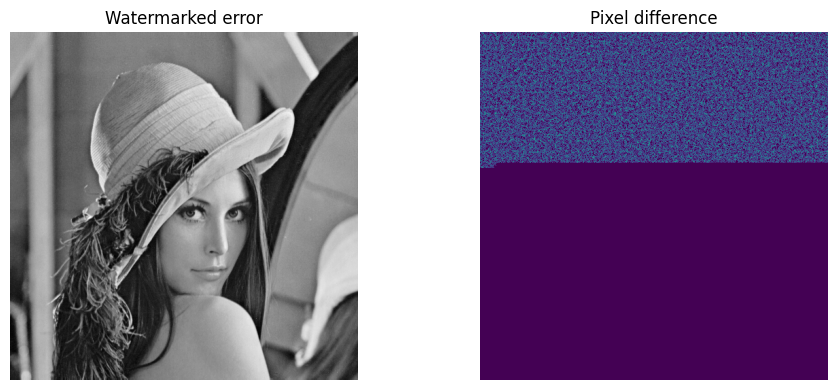

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img_watermarked, cmap='gray')
ax[1].imshow(np.abs(img_watermarked.astype(float) - img.astype(float)))

# Evaluated over the 150 first rows
MSE = ((img_watermarked.astype(float) - img.astype(float))**2).mean()
PSNR = 10 * np.log10(255**2/MSE)

print("MSE: {:.5} pix²".format(MSE))
print("PSNR: {:.5} db".format(PSNR))


for i in range(2):
    ax[i].axis("off")

ax[0].set_title("Watermarked error")
ax[1].set_title("Pixel difference")

plt.tight_layout()
fig.savefig("img_readme/Diff.png")

## Decode

In [8]:
seq_est = md.decode(img, img_watermarked)

In [9]:
# If no noise, able to recover the sequence without problem.
# Otherwise, need to ensure same size.

l = min(len(seq_est), len(seq))
acc = np.mean(seq_est[:l] == seq[:l])
print("Recovery accuracy: {:.4} % for alpha={}".format(acc * 100, md.alpha))

Recovery accuracy: 99.98 % for alpha=2


----

# Error Analysis

See how different the watermarked image is from the original

In [10]:
n = 106496# Use the maximal number of pixels
seq = np.random.randint(0, 2, n)

## Encode

In [11]:
img_watermarked = md.encode(img, seq)

MSE: 1.7089 pix²
PSNR: 45.804 db


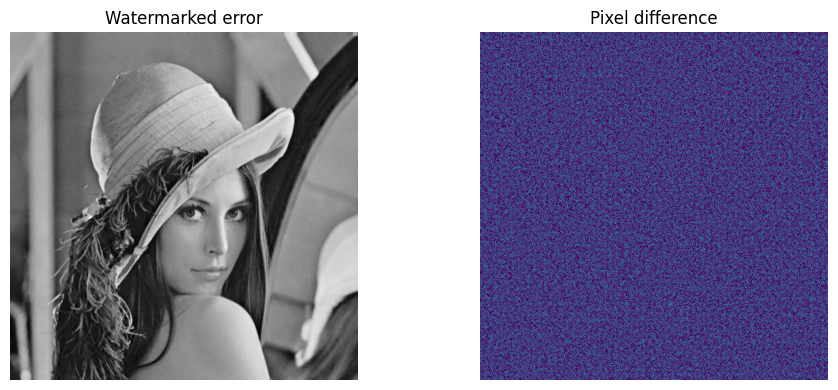

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img_watermarked, cmap='gray')
ax[1].imshow(np.abs(img_watermarked.astype(float) - img.astype(float)))

# Evaluated over the 150 first rows
MSE = ((img_watermarked.astype(float) - img.astype(float))**2).mean()
PSNR = 10 * np.log10(255**2/MSE)

print("MSE: {:.5} pix²".format(MSE))
print("PSNR: {:.5} db".format(PSNR))


for i in range(2):
    ax[i].axis("off")

ax[0].set_title("Watermarked error")
ax[1].set_title("Pixel difference")

plt.tight_layout()
fig.savefig("img_readme/Diff_all.png")

## Histogram

Compare color curves

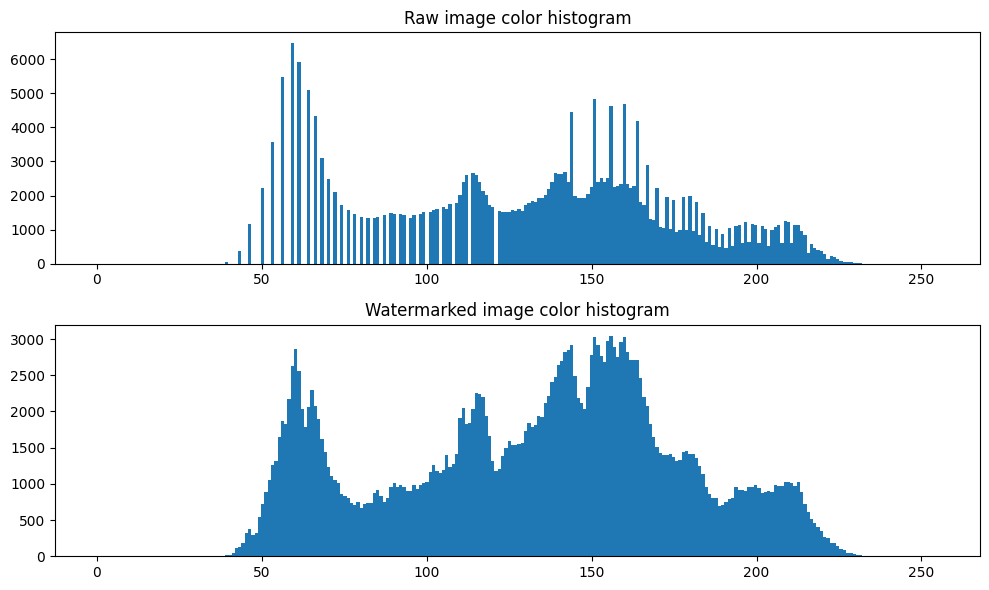

In [13]:
fig, ax = plt.subplots(2, figsize=(10, 6))
ax[0].hist(img.reshape(-1), 256, range=(0, 255))
ax[1].hist(img_watermarked.reshape(-1), 256, range=(0, 255));
ax[0].set_title('Raw image color histogram')
ax[1].set_title('Watermarked image color histogram')
plt.tight_layout()
fig.savefig("img_readme/histograms.png")


## Alpha impact

In [14]:
md = BlockMark(mode="add", alpha=2)
img_watermarked = md.encode(img, seq)

MSE = ((img_watermarked.astype(float) - img.astype(float))**2).mean()
PSNR = 10 * np.log10(255**2/MSE)
seq_est = md.decode(img, img_watermarked)

print("MSE: {:.5} pix²".format(MSE))
print("PSNR: {:.5} db".format(PSNR))
print("Acc: {:.4} %".format(100 * np.mean(seq_est == seq)))



MSE: 1.7089 pix²
PSNR: 45.804 db
Acc: 99.97 %


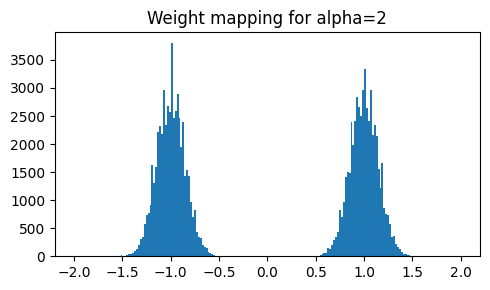

In [15]:
seq_est = md.decode(img, img_watermarked, quantization=False)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set_title("Weight mapping for alpha={}".format(md.alpha))
plt.hist(seq_est, 200, range=(-2, 2));
plt.tight_layout()
fig.savefig('img_readme/histogram_add_{}.png'.format(md.alpha))


----

# QR code embedding

The best way to play with a visiual object

In [16]:
import qrcode # install the library if needed with pip

In [17]:
img = qrcode.make('I am an imposter !'*60)

# Convert PIL image to Numpy (binary image)
img_arr = np.array(img.get_image())
l0, l1 = img_arr.shape

# Initial image has "squares" of 10 pixel wide. Here, unecessary
img_min = cv2.resize(img_arr.astype(np.uint8), (l0//10, l1//10))
print(img_min.shape)


l_qrcode = len(img_min)
msg = img_min.reshape(-1)
print("Message length: {}".format(len(msg)))

(133, 133)
Message length: 17689


##### Setup model and select

In [18]:
img_lenna = cv2.imread("img/lenna.png", 0)

md = BlockMark(alpha=2, mode="add")

print("Maximal capacity (bits):", md.get_max_capacity(img_lenna))


Maximal capacity (bits): 106496


##### Encoding

In [19]:
img_wat = md.encode(img_lenna, msg)

##### Decoding

In [20]:
msg_rec = md.decode(img_lenna, img_wat)

In [21]:
print(len(msg_rec), "VS", len(msg))
print("Accuracy: {:.4} %".format((msg_rec[:len(msg)] == msg).mean()*100))

17689 VS 17689
Accuracy: 99.98 %


##### Recreate the image

In [22]:
img_rec = msg_rec[:l_qrcode**2].reshape(l_qrcode, -1).clip(0, 1) 

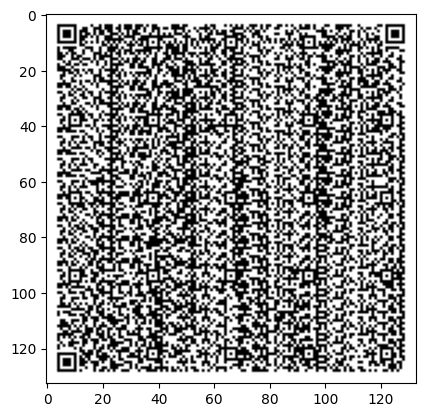

In [23]:
plt.imshow(img_rec, cmap="gray")